In [21]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import brier_score_loss
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from scipy.stats import randint, uniform, loguniform
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [22]:
X1 = pd.read_csv("preprocessed_datasets/bank_data.csv")
y1 = pd.read_csv("preprocessed_datasets/bank_target.csv").squeeze()
X2 = pd.read_csv("preprocessed_datasets/gym_data.csv")
y2 = pd.read_csv("preprocessed_datasets/gym_target.csv").squeeze()
X3 = pd.read_csv("preprocessed_datasets/heartDisease_data.csv")
y3 = pd.read_csv("preprocessed_datasets/heartDisease_target.csv").squeeze()
X4 = pd.read_csv("preprocessed_datasets/titanic_data.csv")
y4 = pd.read_csv("preprocessed_datasets/titanic_target.csv").squeeze()

In [23]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42, stratify=y1)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42, stratify=y2)
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2, random_state=42, stratify=y3)
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size=0.2, random_state=42, stratify=y4)




In [24]:
datasets = [
    (X1_train, X1_test, y1_train, y1_test, "Bank"),
    (X2_train, X2_test, y2_train, y2_test, "Gym"),
    (X3_train, X3_test, y3_train, y3_test, "Heart Disease"),
    (X4_train, X4_test, y4_train, y4_test, "Titanic")
]
baseline_brier_scores = []


for X_train, X_test, y_train, y_test, _ in tqdm(datasets, desc="Processing datasets"):
    model = make_pipeline(
        StandardScaler(),
        SVC(kernel='rbf', probability=True, random_state=42)
    )
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_test)[:, 1]
    brier = brier_score_loss(y_test, y_proba)
    baseline_brier_scores.append(brier)

for i, (brier, (_, _, _, _, dataset_name)) in enumerate(zip(baseline_brier_scores, datasets), 1):
    print(f"Dataset {i} ({dataset_name}): Baseline Brier score = {brier:.4f}")

Processing datasets:   0%|          | 0/4 [00:00<?, ?it/s]

Dataset 1 (Bank): Baseline Brier score = 0.1893
Dataset 2 (Gym): Baseline Brier score = 0.1687
Dataset 3 (Heart Disease): Baseline Brier score = 0.0998
Dataset 4 (Titanic): Baseline Brier score = 0.1712



### Random search optimization

In [25]:
N_ITER = 100
RANDOM_STATE = 42
SCORER = 'neg_brier_score'  # maximize negative value because in standard brier score the lower, the better
WINDOW_SIZE = 10           
ABS_TOL = 0.001 
CV = 5

In [26]:
pipeline = make_pipeline(
    StandardScaler(),
    SVC(kernel='rbf', probability=True, random_state=42)
)
param_distributions = {
    'svc__C': loguniform(1e-3, 1e3),
    'svc__gamma': loguniform(1e-4, 1e1)
}
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=N_ITER,
    scoring=SCORER,
    cv=CV,
    verbose=1,
    n_jobs=-1,
    random_state=RANDOM_STATE,
    refit=True
)
tuned_brier_scores = []
best_params_list = []
cv_results_list = []



In [27]:
def chart_random(stabilized_at, brier_per_iter, iters, best_so_far, dataset_name):
    plt.figure(figsize=(10, 5))
    plt.scatter(iters, brier_per_iter, s=12, alpha=0.6, label='Brier per iteration')
    plt.plot(iters, best_so_far, linewidth=2, label='Best so far')
    if stabilized_at is not None:
        plt.axvline(stabilized_at, linestyle='--', linewidth=1, label=f'Stabilized at {stabilized_at}')
    plt.xlabel('Iteration')
    plt.ylabel('Brier score (lower is better)')
    plt.title(f'Brier per Random Search iteration and best-so-far for {dataset_name}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [28]:
def detect_stabilization_by_last(best_so_far, abs_tol=ABS_TOL, window_len=WINDOW_SIZE):
    """
    Szuka pierwszego okna długości window_len takie, że wszystkie window_len-1 kolejnych różnic
    między elementami okna mają wartość absolutną < abs_tol.
    Zwraca (stabilized_at_1based, stabilized_value) lub (None, None).
    """
    arr = np.asarray(best_so_far)
    n = arr.shape[0]
    if n < window_len:
        return None, None

    for start in range(0, n - window_len + 1):
        window = arr[start:start + window_len]
        diffs = np.abs(np.diff(window))
        if np.all(diffs < abs_tol):
            return start + 1, float(window[0])
    return None, None


Tuning datasets:   0%|          | 0/4 [00:00<?, ?it/s]

Fitting 5 folds for each of 100 candidates, totalling 500 fits


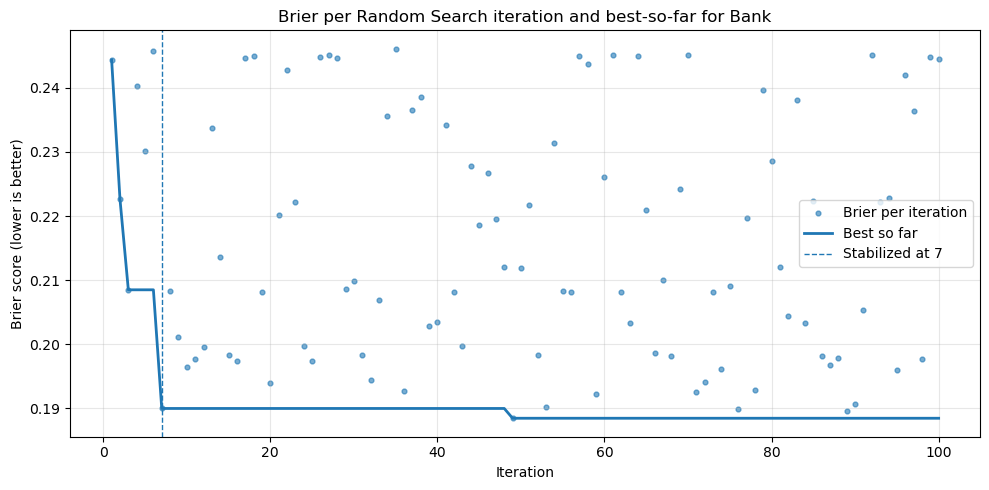

Fitting 5 folds for each of 100 candidates, totalling 500 fits


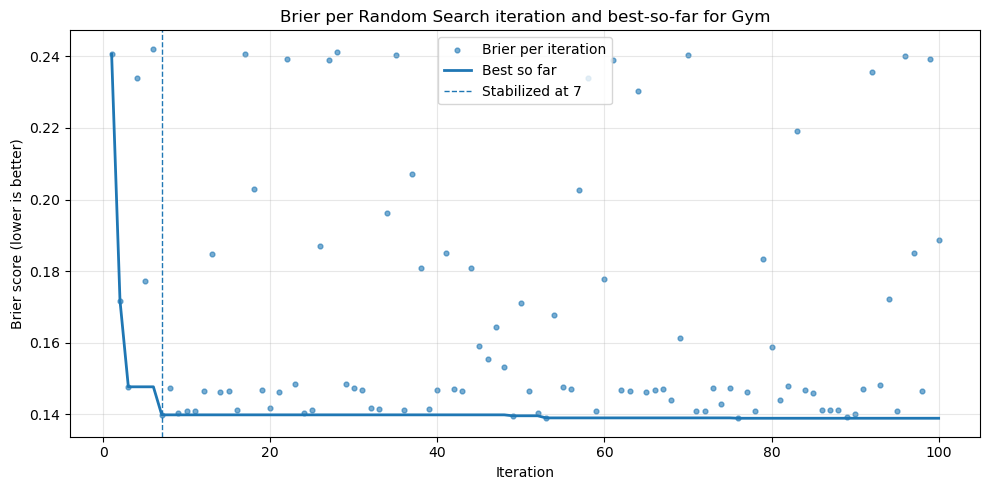

Fitting 5 folds for each of 100 candidates, totalling 500 fits


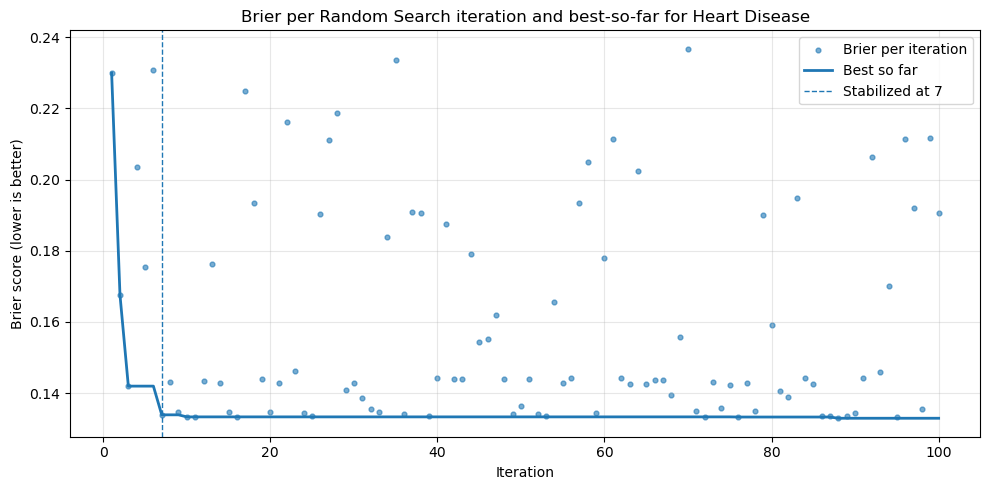

Fitting 5 folds for each of 100 candidates, totalling 500 fits


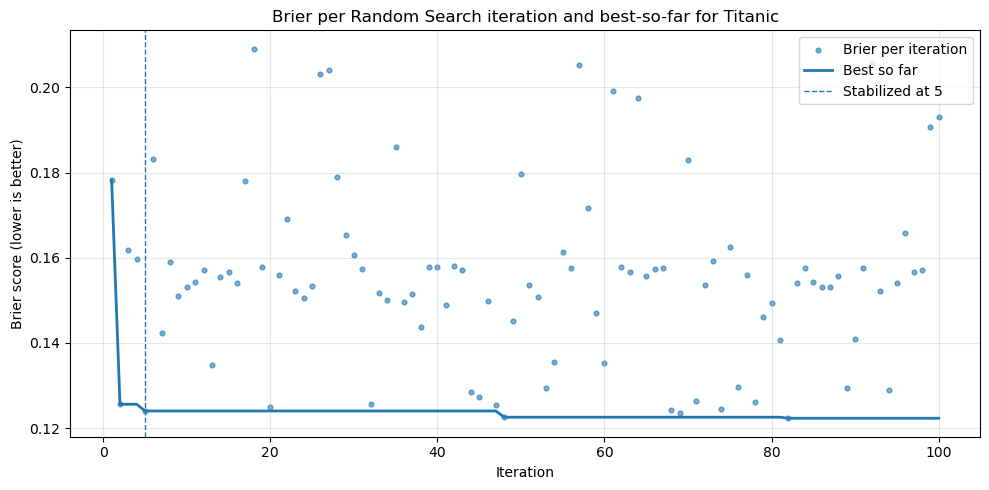

In [29]:

for X_train, X_test, y_train, y_test, dataset_name in tqdm(datasets, desc="Tuning datasets"):
    random_search.fit(X_train, y_train)
    best_params = random_search.best_params_
    best_params = {'C': best_params['svc__C'], 'gamma': best_params['svc__gamma']}

    model = make_pipeline(
        StandardScaler(),
        SVC(kernel='rbf', probability=True, random_state=42, **best_params)
    )
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_test)[:, 1]
    brier = brier_score_loss(y_test, y_proba)
    tuned_brier_scores.append(brier)
    best_params_list.append(best_params)
    cv_results_list.append(random_search.cv_results_)

    # Extract CV results for visualization
    cv_results = random_search.cv_results_
    param_C = cv_results['param_svc__C'].data
    param_gamma = cv_results['param_svc__gamma'].data
    mean_test_score = -cv_results['mean_test_score']  # Negate if using neg_log_loss
    best_so_far = np.minimum.accumulate(mean_test_score)

    # Detect stabilization
    stabilized_at, stabilized_value = detect_stabilization_by_last(best_so_far, abs_tol=ABS_TOL, window_len=WINDOW_SIZE)

    # Prepare data for plotting
    iters = np.arange(1, len(mean_test_score) + 1)
    brier_per_iter = mean_test_score  # Brier scores per iteration

    # Plot the results for this dataset
    chart_random(stabilized_at, brier_per_iter, iters, best_so_far, dataset_name)

In [30]:
for i, (brier, baseline_brier, (_, _, _, _, dataset_name)) in enumerate(zip(tuned_brier_scores, baseline_brier_scores, datasets), 1):
    print(f"Dataset {i} ({dataset_name}): Tuned Brier score = {brier:.4f}, Baseline Brier score = {baseline_brier:.4f}")

Dataset 1 (Bank): Tuned Brier score = 0.1893, Baseline Brier score = 0.1893
Dataset 2 (Gym): Tuned Brier score = 0.1676, Baseline Brier score = 0.1687
Dataset 3 (Heart Disease): Tuned Brier score = 0.1086, Baseline Brier score = 0.0998
Dataset 4 (Titanic): Tuned Brier score = 0.1645, Baseline Brier score = 0.1712


In [31]:
for i, (brier, params, (_, _, _, _, dataset_name)) in enumerate(zip(tuned_brier_scores, best_params_list, datasets), 1):
    print(f"Dataset {i} ({dataset_name}): Tuned Brier score = {brier:.4f}, Best C = {params['C']:.4f}, Best gamma = {params['gamma']:.4f}")

Dataset 1 (Bank): Tuned Brier score = 0.1893, Best C = 1.3690, Best gamma = 0.0137
Dataset 2 (Gym): Tuned Brier score = 0.1676, Best C = 281.5758, Best gamma = 0.0016
Dataset 3 (Heart Disease): Tuned Brier score = 0.1086, Best C = 7.4308, Best gamma = 0.0007
Dataset 4 (Titanic): Tuned Brier score = 0.1645, Best C = 6.3267, Best gamma = 0.0477
